# Blackjack

### Random Action Player

100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


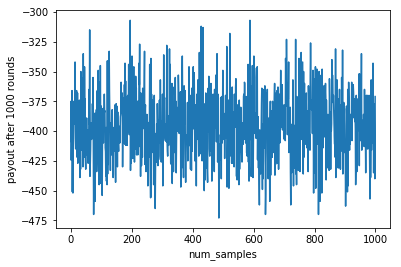

Average payout after 1000 rounds is -395.693


In [1]:
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
%matplotlib inline
env = gym.make('Blackjack-v0')
env.reset()

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

for sample in tqdm(range(num_samples)):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        action = env.action_space.sample()  # take random action
        #print(action) # 0 or 1
        obs, payout, is_done, _ = env.step(action)
        #print(payout)
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

## DQN Agent

In [3]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.
/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
class QMemoryUnit():
    def __init__(self, state, action, reward, done, next_state):
        self.state = state
        self.action = action
        self.reward = reward
        self.done = done
        self.next_state = next_state

In [5]:
memory_size = 5000
episodes = 1000
epsilon = 0.1
gamma = 0.1
minibatch_size = 512

model = Sequential()
model.add(Dense(32, input_dim=4, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=Adam())

memory = deque(maxlen=memory_size)
env = gym.make('Blackjack-v0')

#valid actions
action_space = np.array([0,1])

#state + actions
action_state = np.zeros((2,4))

rewards = []
for episode in range(episodes):
    done = False
    state = np.array(env.reset())
    total_reward = 0
    while(not done):
        action_state[:,:3] = state
        action_state[:,3] = action_space
        
        #random choice
        if(random.random() < epsilon):
            action = np.random.choice(action_space)
        
        #action with greatest expected value
        else:
            action = np.argmax(model.predict(action_state))
            
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        memory.append(QMemoryUnit(state, action, reward, done, next_state))
        state = next_state
        
        minibatch = np.zeros((minibatch_size, 4))
        labels = np.zeros(minibatch_size)
        #generate minibatch and labels
        for i in range(minibatch_size):
            index = np.random.randint(0, len(memory))
            sample = memory[index]
            
            reward = sample.reward
            if(not sample.done):
                action_state[:,:3] = sample.next_state
                action_state[:,3] = action_space
                reward += gamma * np.max(model.predict(action_state))
            
            minibatch[i,:3] = sample.state
            minibatch[i,3] = sample.action
            labels[i] = reward
            
        model.fit(minibatch, labels, verbose=0)
    rewards.append(total_reward)

100%|██████████| 1000/1000 [20:54<00:00,  1.25s/it]


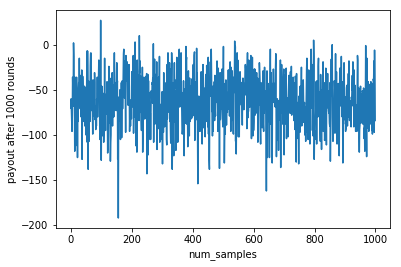

Average payout after 1000 rounds is -63.468


In [6]:
import gym
import matplotlib.pyplot as plt

env = gym.make('Blackjack-v0')
state = env.reset()
num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

for sample in tqdm(range(num_samples)):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        action_state[:,:3] = state
        action_state[:,3] = action_space
        action = np.argmax(model.predict(action_state))
        state, payout, is_done, _ = env.step(action)
        #print(payout)
        total_payout += payout
        if is_done:
            state = env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

fig = plt.figure()
plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))